# **Image denoising using Noise2Void 3D**

---

<font size = 4> Noise2Void 3D is deep-learning method that can be used to denoise 3D microscopy images (xyz). By running this notebook, you can train your own network and denoise your images. 
---

*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **Noise2Void - Learning Denoising from Single Noisy Images**
Alexander Krull, Tim-Oliver Buchholz, Florian Jug
https://arxiv.org/abs/1811.10980

And source code found in: https://github.com/juglab/n2v



**Please also cite this original paper when using or developing this notebook.**


# **How to use this notebook?**

---
###**Structure of a notebook**

A notebook is conveniently made of text annotation that describe the code and workflow (**Text cells**) as well as sections that contain the code that is executed (**Code cells**).  

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appears). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Table of contents, Code snippets** and **Files**

On the top left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files.

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything in here!

---
###**Making changes to the notebook**

**You can make a copy** of the notebook and save it to your Google Drive. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
You can use the `#`-mark in code cells to comment out parts of the code. This allows you to keep the original code piece in the cell as a comment.

#**0. Before getting started**
---
<font size = 4>

Before you run the notebook, please ensure that you are logged into your Google account and have the training and/or data to process in your Google Drive.

**Important Notes**
For Noise2Void to train, it only requires a single noisy image.


Please note that you currently can **only use .tif files!**

You can also provide a folder that contains the data that you wish to analyse with the trained network once all training has been performed. This can include Test dataset for which you have the equivalent output and can compare to what the network provides.

Here's a common data structure that can work:

*   Data
    - Training dataset      
    - Test dataset 
    - Results


The **Results** folder will contain the processed images, trained model and network parameters as csv file. Your original images remain unmodified.

---


# **1. Set the Runtime type and mount your Google Drive**



### **1.1 Change the Runtime**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


In [1]:
#@title Run this cell to check if you have GPU access
%tensorflow_version 1.x

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime settings are correct then Google did not allocate GPU to your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')
  

You have GPU access


### **1.2. Mount Google Drive**
<font size = 4> To use this notebook on the provided data, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will allow Colab to have access to the data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [2]:
#@markdown Play the cell to Mount your Google Drive.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install Noise2Void**

In [3]:
#@markdown ###Install Noise2Void and dependencies

# Enable the Tensorflow 1 instead of the Tensorflow 2.
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

print("Tensorflow enabled.")

# Instal Noise2Void
!pip install n2v

print("Noise2Void installed.")

# Here we install all libraries and other depencies to run the notebook.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os, random
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
import pandas as pd
import csv
from pathlib import Path

!pip install memory_profiler
%load_ext memory_profiler

print("Libraries installed")

1.15.0
Tensorflow enabled.
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 133kB 51.7MB/s 
     |████████████████████████████████| 18.1MB 199kB/s 
Noise2Void installed.


Using TensorFlow backend.


  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=f6d021710c530778df6707f579a214143ea42879fb270a9cd29e1cb773a291b4
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
Successfully built memory-profiler
Libraries installed


# **3. Select your parameters and paths**

<font size = 5> **Paths for training, predictions and results**

<font size = 4>**`Training_source:`:** These is the path to your folders containing the Training_source (noisy images). To find the path of the folder containing your datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model. 

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder)


<font size = 5>**Training Parameters**

<font size = 4>**`number_of_steps`:** Good network training may require at least 300 steps but will take a while. **Default value: 100**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) network will be trained. A larger number of epochs may improve performance but risks overfitting to the training data. Start with 30-100 and test the performance after training (see 4.8.). **Default value: 30**

<font size = 4>**`patch_size`:** Noise2Void divides the image into patches for training. Input the size of the patches (length of a side). The value should be smaller than the dimensions of the image and divisible by 8. **Default value: 32 or 64**

<font size = 4>**`number_of_patches`:** Input the number of the patches per image. Increasing the number of patches allows for larger training datasets. **Default value: 100** 


<font size = 4>**`patch_height`:** The value should be smaller than the Z dimensions of the image. 

<font size = 4>**Decreasing the patch size or increasing the number of patches may improve the training but may also increase the training time.**



Parameters initiated.


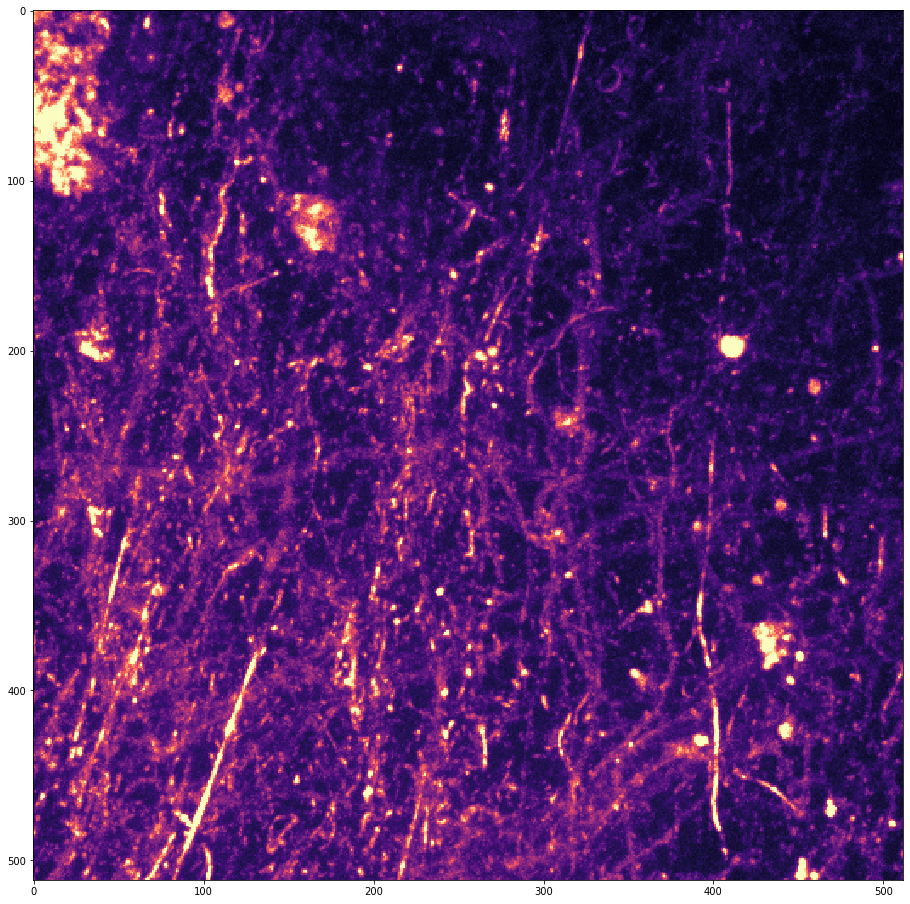

In [6]:
# Create DataGenerator-object.
datagen = N2V_DataGenerator()

#@markdown ###Path to training images: 
Training_source = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/Training - Images/migration/Fibronectin" #@param {type:"string"}

#compatibility to easily change the name of the parameter
training_images = Training_source
imgs = datagen.load_imgs_from_directory(directory = training_images, dims='ZYX')

#@markdown ### Model name and path:
model_name = "FN_03" #@param {type:"string"}

#compatibility to easily change the name of the parameter
my_model = model_name

model_path = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets" #@param {type:"string"}

#compatibility to easily change the name of the parameter
path_model = model_path

#@markdown ###Training Parameters
#@markdown Number of steps and epochs:
number_of_steps = 100 #@param {type:"number"}

#compatibility to easily change the name of the parameter
steps = number_of_steps

number_of_epochs =  40#@param {type:"number"}
#compatibility to easily change the name of the parameter
epochs = number_of_epochs

#@markdown Patch size (pixels) and number
patch_size = 64 #@param {type:"number"}

#compatibility to easily change the name of the parameter
size = patch_size
width = size

patch_height = 8 #@param {type:"number"}
height = patch_height

number_of_patches =  50#@param {type:"number"}

#compatibility to easily change the name of the parameter
number = number_of_patches
print("Parameters initiated.")

# create the plot to look maximum projection of the volume.
# the code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=0), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

#**4. Train your network**

### **4.1. Prepare the training data and model for training**
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

Generated patches: (400, 8, 64, 64, 1)
400 patches created.
375 patch images for training.
25 patch images for validation (6.25 %).
peak memory: 746.84 MiB, increment: 0.23 MiB




Parameters transferred into the model.


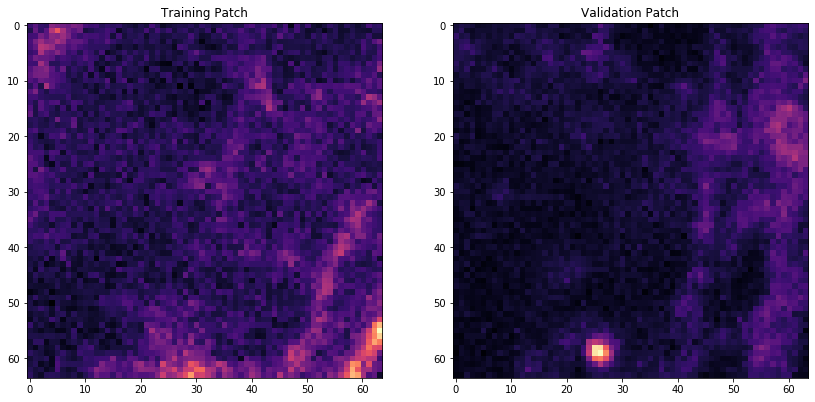

In [7]:
#@markdown ###Create the model and dataset objects

# Create batches from the training data.
# The code is inspired from the original notebook (https://github.com/juglab/n2v)
patches = datagen.generate_patches_from_list(imgs[:1], num_patches_per_img=number,shape=(height, width, width))

# Patches are divited into training and validation patch set. This inhibits over-lapping of patches. 
number_train_images =len(patches)-int(len(patches)*0.0625)
X = patches[:number_train_images]
X_val = patches[number_train_images:]

print(len(patches),"patches created.")
print(number_train_images,"patch images for training.")
print((len(patches)-number_train_images),"patch images for validation (6.25 %).")
%memit 

# creates Congfig object. 
# The code is from the original notebook (https://github.com/juglab/n2v)
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=steps,train_epochs=epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=number, n2v_perc_pix=1.6, n2v_patch_shape=(height, size, size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

vars(config)

# a name used to identify the model. Change the name of the variable.
model_name = my_model

# the base directory in which our model will live
basedir = path_model

# Create the default model.
model = N2V(config=config, name=model_name, basedir=basedir)
print("Parameters transferred into the model.")

# Shows a training batch and a validation batch.
# The code is from the original notebook (https://github.com/juglab/n2v)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,1,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,2,...,0],cmap='magma')
plt.title('Validation Patch');





### **4.2. Train the network**
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches. Another way circumvent this is to save the parameters of the model after training and start training again from this point.

In [0]:
#@markdown ## Start training
%memit
# the training starts.
# The code is from the original notebook (https://github.com/juglab/n2v)
history = model.train(X, X_val)
%memit
print("Training the network, done.")

peak memory: 826.68 MiB, increment: 0.00 MiB



Preparing validation data:   0%|          | 0/50 [00:00<?, ?it/s]

524 blind-spots will be generated per training patch of size (8, 64, 64).


Preparing validation data: 100%|██████████| 50/50 [00:00<00:00, 191.09it/s]










The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/40
100/100 [==============================] - 102s 1s/step - loss: 0.2204 - n2v_mse: 0.2204 - n2v_abs: 0.3235 - val_loss: 0.1571 - val_n2v_mse: 0.1571 - val_n2v_abs: 0.2978

Epoch 2/40
100/100 [==============================] - 86s 861ms/step - loss: 0.1385 - n2v_mse: 0.1385 - n2v_abs: 0.2771 - val_loss: 0.1438 - val_n2v_mse: 0.1438 - val_n2v_abs: 0.2880
Epoch 3/40
100/100 [==============================] - 88s 885ms/step - loss: 0.1305 - n2v_mse: 0.1305 - n2v_abs: 0.2706 - val_loss: 0.1436 - val_n2v_mse: 0.1436 - val_n2v_abs: 0.2856
Epoch 4/40
100/100 [==============================] - 87s 875ms/step - loss: 

### **4.3. Evaluate the training**



<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its 'GT' target.

<font size = 4>**Validation error** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease even after further training. Comparing the development of the validation error with the training error can give insights into the model's performance.

<font size = 4>If **validation error is clearly higher than training error**, it means that the training data might be too complex or diverse. In this case, the trained network fails to improve unseen images. To avoid this, increase the number of epochs and check if you can improve your dataset with more examples.

<font size = 4>If **validation error is clearly smaller than training error**, it means that training data is too simple which allows the network to learn the training data perfectly but to perform poorly on unseen data. This is called overfitting which should be always be avoided as it can lead to artefacts in the predctions of the network. First steps to avoid this can be to reduce the number of training epochs or to use a larger training dataset.

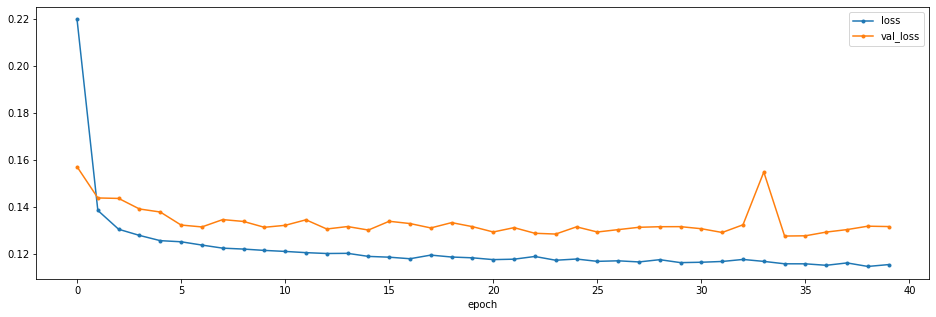

In [0]:
#@markdown ###Play the cell to show a plot of training errors vs. epoch number

# data contains several values and they can be printed by this code. Just remove the #-mark.
# print(sorted(list(history.history.keys()))) 

#@title Play the cell to show figure of training results
# The code is inspired by the original code (https://github.com/CSBDeep/CSBDeep).
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as training evaluation.csv (refresh the Files if needed). 
RESULTS = model_path+'/training evaluation.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))

# Here we look at one resulting image



100%|██████████| 32/32 [00:02<00:00, 19.74it/s]


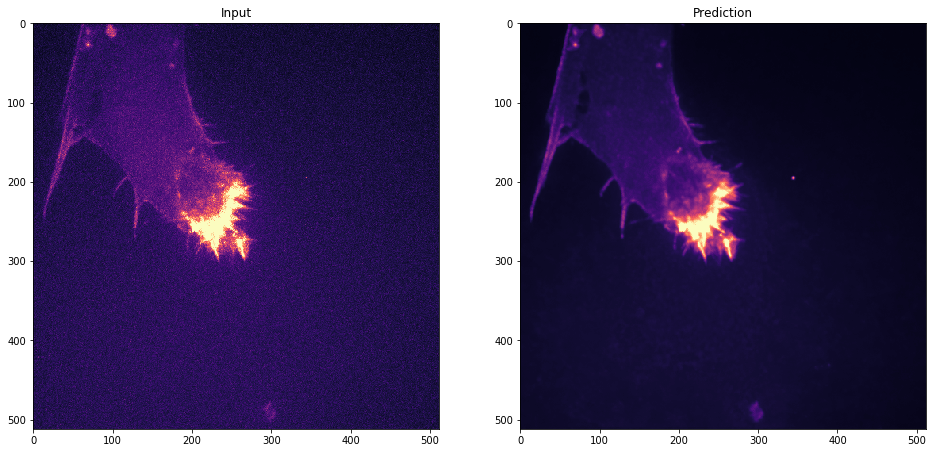

In [0]:
#@markdown ###Play the cell to look at your image after denoising
# We load the data we want to process.
img = imgs[0][0,...,0]

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

# Let's look at the results.
plt.figure(figsize=(16,8))

# We show the noisy input...
plt.subplot(1,2,1)
plt.imshow(np.max(img,axis=0),
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Input');

# and the result.
plt.subplot(1,2,2)
plt.imshow(np.max(pred,axis=0), 
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Prediction');

### **4.4. Export model to be used with *CSBDeep Fiji plugins* and *KNIME* workflows (Experimental !!!)**

<font size = 4>This allows you to save the trained model in a format where it can be used in the CSBDeep Fiji Plugin. See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

<font size = 4>After saving the model to your drive, download the .zip file from your google drive. Do this from your Google Drive and not in the colab interface as this takes very long.

In [0]:
#@markdown ###Play this cell to save a Fiji compatible model to Google Drive.

# The code is from the original notebook (https://github.com/juglab/n2v)
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmpls4g3eur/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/N2V 3D/Filopodia_WF_dataset_low/results/N2V3D-filopodia-low/TF_SavedModel.zip


### **4.5. Download your model(s) from Google Drive**
The model and its parameters have been saved to your **model_path** on your Google Drive. It is however wise to download the folder as all data can be erased at the next training if using the same folder.

# **5. Use the network**

---

<font size = 4>In this section your data is processed using the trained model (in section 4). First we upload your unseen images and prepare them for prediction. After that we activate your trained model from section 4 and finally we save results into your Google Drive.

### **5.1. Generate prediction from test dataset**

<font size = 4>The current trained model (from section 4.2) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Result_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Test_data_folder`:** This folder should contains the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output images.

Using current trained network
Loading network weights from 'weights_best.h5'.
Denoising images...
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN/Position 2_11-45.tif
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN/Position 2_11-46.tif
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN/Position 2_11-47.tif
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN/Position 2_11-49.tif
/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN/Position 2_11-48.tif
/conten

 12%|█▎        | 4/32 [00:00<00:00, 30.27it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.08it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.31it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.90it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.55it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.87it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:01, 27.97it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:01, 27.91it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.00it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.62it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.44it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:00, 29.44it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.29it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.21it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.45it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:01, 28.43it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:00, 29.89it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.94it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.73it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:01, 28.58it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:01, 28.15it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 30.05it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.61it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:00, 29.96it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.21it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.34it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.20it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.52it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.07it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.80it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.82it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:01, 28.73it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.95it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.18it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:00, 29.48it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.59it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.61it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


  9%|▉         | 3/32 [00:00<00:00, 29.15it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.52it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.93it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 30.07it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.42it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.95it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.34it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.20it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.45it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 28.31it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


 12%|█▎        | 4/32 [00:00<00:00, 29.14it/s]

The input image is of type uint16 and will be casted to float32 for prediction.


100%|██████████| 32/32 [00:01<00:00, 20.89it/s]


Prediction of images done.
One example is displayed here.


Text(0.5, 1.0, 'Prediction (single Z plane)')

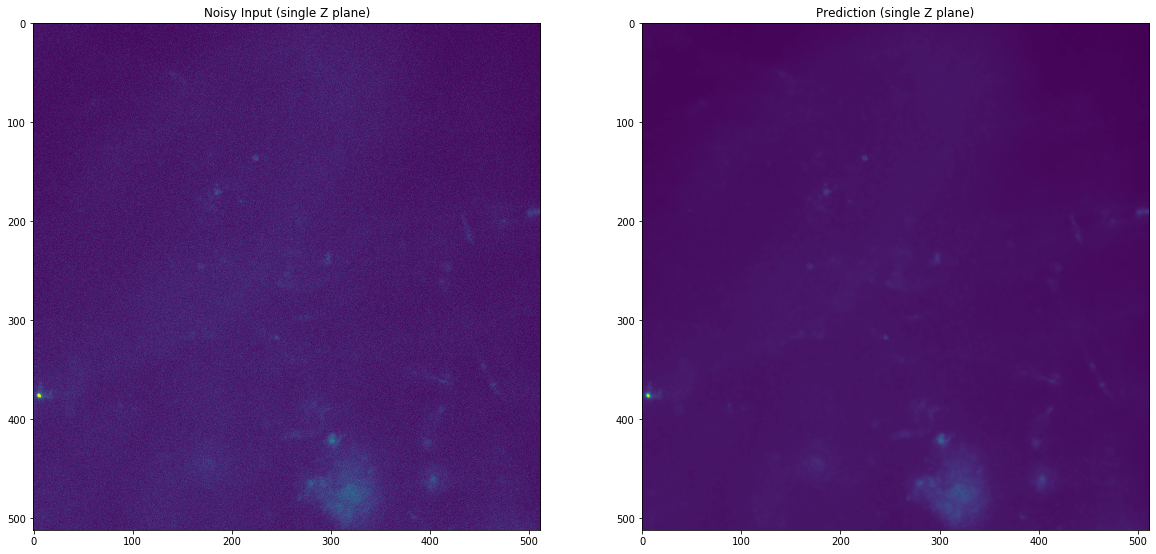

In [0]:
#Activate the pretrained model. 
#model_training = CARE(config=None, name=model_name, basedir=model_path)

#@markdown ### Provide the path to your dataset and to the folder where the prediction will be saved, then play the cell to predict output on your unseen images.

#@markdown ###Path to data to analyse and where predicted output should be saved:
Test_data_folder = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/test FN" #@param {type:"string"}
Result_folder = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Noise2Void (3D)/Results" #@param {type:"string"}


# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the name of the model and path to model folder:
inference_model_name = "CARE2D_myhigh3" #@param {type:"string"}
inference_model_path = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/CARE (2D)/Results" #@param {type:"string"}

if (Use_the_current_trained_model): 
  print("Using current trained network")
  inference_model_name = model_name
  inference_model_path = model_path

#Activate the pretrained model.
config = None
model = N2V(config, inference_model_name, basedir=inference_model_path)

print("Denoising images...")

thisdir = Path(Test_data_folder)
outputdir = Path(Result_folder)
suffix = '.tif'

# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".tif" in file:
            print(os.path.join(r, file))

# The code by Lucas von Chamier
for r, d, f in os.walk(thisdir):
  for file in f:
    base_filename = os.path.basename(file)
    input_train = imread(os.path.join(r, file))
    pred_train = model.predict(input_train, axes='ZYX', n_tiles=(2,4,4))
    save_tiff_imagej_compatible(os.path.join(outputdir, base_filename), pred_train, axes='ZYX')         
print("Prediction of images done.")

print("One example is displayed here.")


#Display an example
random_choice=random.choice(os.listdir(Test_data_folder))
x = imread(Test_data_folder+"/"+random_choice)

os.chdir(Result_folder)
y = imread(Result_folder+"/"+random_choice)

f=plt.figure(figsize=(20,40))
plt.subplot(1,2,1)

plt.imshow(x[2], interpolation='nearest')
plt.title('Noisy Input (single Z plane)')
plt.subplot(1,2,2)

plt.imshow(y[2], interpolation='nearest')
plt.title('Prediction (single Z plane)')

### **5.2. Download your predicted output**

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will otherwise **OVERWRITE** all files which have the same name.